# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
import keras
import keras_tuner as kt
import xgboost as xgb

from random import gauss
from random import seed

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error,r2_score

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from arch import arch_model

from pmdarima import auto_arima
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import Hyperband
from keras.models import load_model,Sequential

In [3]:
df = pd.read_csv('../data/cleaned_data/master.csv',index_col=0)
df.head()

,nonglu_price,hommali_price,agri_prod_index,crops_prod_index,paddy_prod_index,nonglu_prod_index,hommali_prod_index,agri_price_index,crops_price_index,paddy_price_index,...,water_station_M7,water_station_N1,water_station_N67,water_station_Ny1B,water_station_P1,water_station_P17,water_station_S4B,water_station_Sw5A,water_station_Y17,water_station_Y1C
date,,,,,,,,,,,,,,,,,,,,,
2006-01-01,6696.0,7628.0,109.703894,114.011647,43.580672,72.649707,8.077559,110.377654,113.821771,100.581118,...,140.50,66.17,520.00,26.85,38.96,679.63,6.23,97.92,1.24,20.25
2006-02-01,6633.0,7873.0,93.049409,91.755084,46.062229,85.832560,0.000000,111.337228,115.390439,101.563145,...,87.75,39.02,501.32,26.22,64.11,573.91,4.69,69.55,0.00,13.07
2006-03-01,6649.0,7960.0,92.803780,87.828340,74.516499,138.854375,0.000000,112.498075,117.876876,103.063764,...,108.95,20.94,558.72,42.23,68.26,523.38,2.23,60.02,2.32,35.51
2006-04-01,6880.0,8028.0,75.452369,67.662286,66.215260,123.385807,0.000000,115.595159,121.878356,104.906097,...,188.40,45.73,692.79,61.08,84.68,508.65,0.06,76.80,5.84,31.54
2006-05-01,6782.0,8069.0,77.366260,68.992476,35.785484,66.682829,0.000000,113.408937,119.725058,104.687875,...,270.30,94.19,1027.25,44.98,146.19,1092.68,34.64,88.76,168.17,268.37


In [4]:
# Set index as datetime
df.index = pd.to_datetime(df.index,format="%Y-%m-%d")

In [5]:
# Check type of value
df.dtypes.value_counts()

float64    49
Name: count, dtype: int64

In [6]:
df.shape

(226, 49)

In [7]:
df.columns

Index(['nonglu_price', 'hommali_price', 'agri_prod_index', 'crops_prod_index',
       'paddy_prod_index', 'nonglu_prod_index', 'hommali_prod_index',
       'agri_price_index', 'crops_price_index', 'paddy_price_index',
       'nonglu_price_index', 'hommali_price_index', 'agri_export_value',
       'rice_export_value', 'rice_export_amount', 'inflation', 'cpi_rice',
       'pol_rate', 'neer', 'reer', 'sirikit_water', 'bhumibol_water',
       'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4',
       'fertilizer_5', 'fertilizer_6', 'water_station_B10',
       'water_station_C13', 'water_station_C2', 'water_station_G8',
       'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
       'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
       'water_station_M6A', 'water_station_M7', 'water_station_N1',
       'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
       'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
       'w

# Model

In [9]:
# Create the target
y = df['nonglu_price']

# Define independent variables (predictors) X
xvars_water_fertilizer = ['hommali_price','hommali_price_index',
                        'fertilizer_1', 'fertilizer_2', 'fertilizer_3', 'fertilizer_4','fertilizer_5', 'fertilizer_6', 
                        'sirikit_water', 'bhumibol_water',
                        'water_station_B10','water_station_C13', 'water_station_C2', 'water_station_G8',
                        'water_station_K10', 'water_station_K11A', 'water_station_Kgt3',
                        'water_station_Kh103', 'water_station_Kh58A', 'water_station_Kh72',
                        'water_station_M6A', 'water_station_M7', 'water_station_N1',
                        'water_station_N67', 'water_station_Ny1B', 'water_station_P1',
                        'water_station_P17', 'water_station_S4B', 'water_station_Sw5A',
                        'water_station_Y17', 'water_station_Y1C']


# Adjust X to match the same periods
X = df[xvars_water_fertilizer]

In [10]:
# Split data into training and test sets
# shuffle=False maintains time order (crucial for time series!)
# test_size=20 reserves last 20 observations for testing

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=25)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 31), (25, 31), (201,), (25,))

## 1. Linear Regression Model

### Model 1: Linear Regression Model

In [13]:
label = 'nonglu_price'
df = df[xvars_water_fertilizer + [label]]

train_data = df[df.index < '2022-10-01']
test_data = df[df.index >= '2022-10-01']

X_train = train_data.drop(columns=['nonglu_price'])
y_train = train_data['nonglu_price']

X_test = test_data.drop(columns=['nonglu_price'])
y_test = test_data['nonglu_price']

In [14]:
# Instantiate and fit an Linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((201, 31), (25, 31), (201,), (25,))

In [16]:
# Prediction
y_pred = lr.predict(X_test)

In [17]:
# Evaluate the Linear Regression Model
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = root_mean_squared_error(y_test, y_pred)
lr_r2 = r2_score(y_test, y_pred)
print(f"Linear Regression Model MSE: {lr_mse:.4f}")
print(f"Linear Regression Model RMSE: {lr_rmse:.4f}")
print(f"Linear Regression Model R-squared: {lr_r2:.4f}")

Linear Regression Model MSE: 3485950.4339
Linear Regression Model RMSE: 1867.0700
Linear Regression Model R-squared: -2.1698


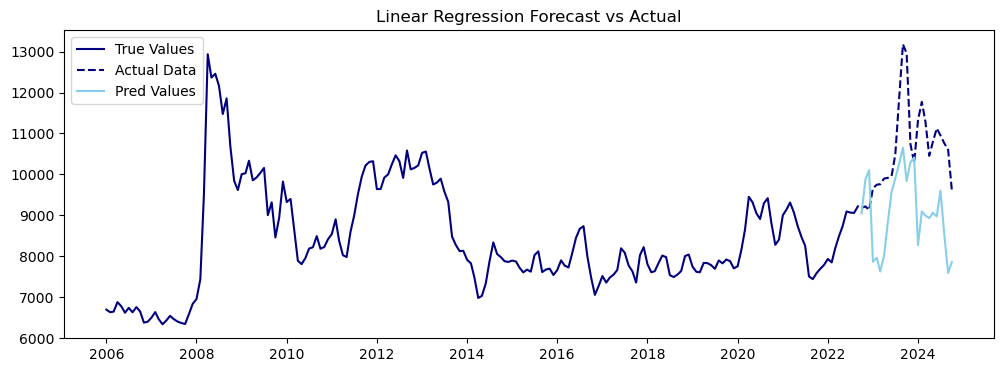

In [18]:
# Plot predictions
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(test_data.index,y_pred, c='skyblue', label='Pred Values')
plt.title("Linear Regression Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/water_fertilizer/Linear Regression Forecast vs Actual.png')
plt.show()

#### Feature importance

In [20]:
#print regression coefficients
pd.DataFrame(zip(X.columns, lr.coef_))

,0,1
0,hommali_price,1.188811e+11
1,hommali_price_index,-9.135024e+12
2,fertilizer_1,-9.073356e-02
3,fertilizer_2,-4.882977e-02
4,fertilizer_3,2.397492e-01
5,fertilizer_4,2.371878e-01
6,fertilizer_5,1.246939e-01
7,fertilizer_6,-2.369034e-01
8,sirikit_water,8.326208e-01
9,bhumibol_water,7.450527e-02


## 2. ARIMA Model

### Model 2 : ARIMA

In [23]:
# # Adding shock event from 2008 rice crisis from January to May 2008
# X_train['shock_event_1'] = [1 if (date >= pd.to_datetime('2008-01-01') and date <= pd.to_datetime('2008-05-01')) 
#                           else 0 for date in  X_train.index]
# X_test['shock_event_1'] = [1 if (date >= pd.to_datetime('2008-01-01') and date <= pd.to_datetime('2008-05-01'))
#                          else 0 for date in  X_test.index]
                           
# # Adding shock event from India lifts export restrictions on rice
# X_train['shock_event_2'] = [1 if (date >= pd.to_datetime('2022-07-01') and date <= pd.to_datetime('2024-09-01')) 
#                           else 0 for date in  X_train.index]
# X_test['shock_event_2'] = [1 if (date >= pd.to_datetime('2022-07-01') and date <= pd.to_datetime('2024-09-01'))
#                          else 0 for date in  X_test.index]

In [24]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax1_model = ARIMA(
    y_train,                 # Dependent variable (nonglu_price)
    exog=X_train,            # External variables 
    order=(2, 1, 2)).fit()   # ARIMA parameters: (p=2, d=1, q=2)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
# Generate predictions on the test set
arimax1_forecast = arimax1_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

In [26]:
# Evaluate the ARIMAX(2,1,2) Model
arimax1_mse = mean_squared_error(y_test, arimax1_forecast)
arimax1_rmse = root_mean_squared_error(y_test, arimax1_forecast)
arimax1_r2 = r2_score(y_test, arimax1_forecast)
print(f"ARIMAX(2,1,2) Model MSE : {arimax1_mse:.4f}")
print(f"ARIMAX(2,1,2) Model RMSE :{arimax1_rmse:.4f}")
print(f"ARIMAX(2,1,2) Model R-squared :{arimax1_r2:.4f}")

ARIMAX(2,1,2) Model MSE : 2551197.4031
ARIMAX(2,1,2) Model RMSE :1597.2468
ARIMAX(2,1,2) Model R-squared :-1.3198


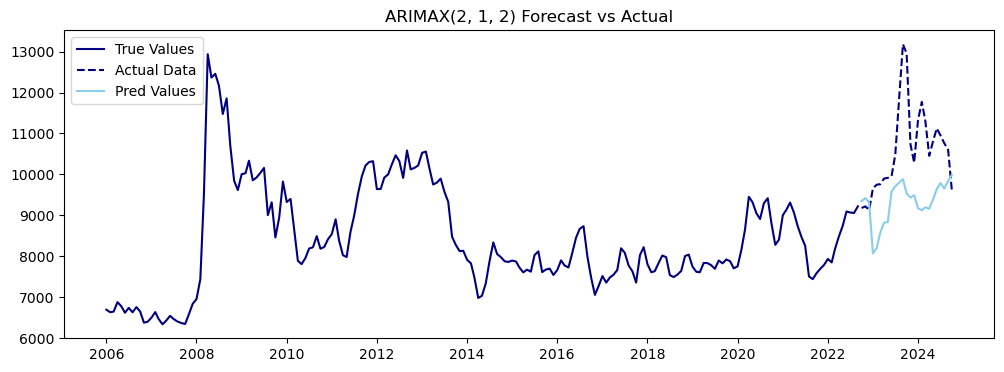

In [27]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax1_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2, 1, 2) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure//water_fertilizer/ARIMAX(2,1,2) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [29]:
arimax1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1450.954
Date:                Thu, 19 Dec 2024   AIC                           2973.907
Time:                        11:21:21   BIC                           3092.647
Sample:                    01-01-2006   HQIC                          3021.959
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
hommali_price           0.3010      0.171      1.761      0.078      -0.034       0.636
hommali_price_index     0.0040     14.630      0.000      1.000     -28.670      28.678
fertilizer_1           -0.0170      0.095     -0.180      0.857      -0.203       0.169
fertilizer_2           -0.0586      0.062     -0.941      0.347      -0.181       0.063
fertilizer_3           -0.0222      0.091     -0.244      0.807      -0.200       0.156
fertilizer_4           -0.0017      0.057     -0.029      0.977      -0.114       0.110
fertilizer_5            0.1846      0.096      1.931      0.054      -0.003       0.372
fertilizer_6            0.0437      0.065      0.675      0.500      -0.083       0.171
sirikit_water           0.9467      0.522      1.812      0.070      -0.077       1.971
bhumibol_water         -0.3264      0.214     -1.526      0.127      -0.746       0.093
water_station_B10       0.2205      1.315      0.168      0.867      -2.356       2.797
water_station_C13      -0.1260      0.110     -1.140      0.254      -0.343       0.091
water_station_C2        0.1594      0.169      0.944      0.345      -0.172       0.490
water_station_G8        0.0926      1.558      0.059      0.953      -2.961       3.146
water_station_K10      -0.3180      0.250     -1.273      0.203      -0.808       0.172
water_station_K11A      0.1841      0.217      0.848      0.397      -0.242       0.610
water_station_Kgt3     -0.0042      0.235     -0.018      0.986      -0.466       0.457
water_station_Kh103     1.5723      2.570      0.612      0.541      -3.465       6.610
water_station_Kh58A    -0.4943      0.560     -0.882      0.378      -1.593       0.604
water_station_Kh72     -1.0994      3.258     -0.337      0.736      -7.486       5.287
water_station_M6A      -0.0211      0.176     -0.120      0.904      -0.365       0.323
water_station_M7       -0.0583      0.058     -1.007      0.314      -0.172       0.055
water_station_N1       -1.3647      0.725     -1.882      0.060      -2.786       0.056
water_station_N67       0.2022      0.199      1.017      0.309      -0.187       0.592
water_station_Ny1B      0.0576      1.515      0.038      0.970      -2.911       3.026
water_station_P1        1.8413      1.474      1.249      0.212      -1.048       4.731
water_station_P17      -0.1037      0.162     -0.641      0.521      -0.421       0.213
water_station_S4B       0.5616      1.413      0.397      0.691      -2.209       3.332
water_station_Sw5A      0.2229      1.044      0.213      0.831      -1.824       2.270
water_station_Y17      -0.1840      0.388     -0.474      0.635      -0.945       0.577
water_station_Y1C      -0.5141      0.453     -1.136      0.256      -1.401       0.373
ar.L1                   0.4955      0.147      3.364      0.001       0.207       0.784
ar.L2                  -0.8208      0.117     -6.991      0.000      -1.051      -0.591
ma.L1                  -0.3149      0.162     -1.938      0.053      -0.6

### Model 3 : Auto ARIMA

In [31]:
# Automatically tune ARIMA parameters
auto_model = auto_arima(
    y_train,exogenous=X_train,
    start_p=0, max_p=4,
    start_q=0, max_q=4,
    d=None,seasonal=False, trace=False,error_action='ignore', suppress_warnings=True, stepwise=True)

# Best parameters
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1497.527
Date:                Thu, 19 Dec 2024   AIC                           3003.053
Time:                        11:21:21   BIC                           3016.267
Sample:                    01-01-2006   HQIC                          3008.400
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    675.8081    219.037      3.085      0.002     246.504    1105.112
ar.L1          1.2125      0.031     39.511      0.000       1.152       1.273
ar.L2         -0.2931      0.038     -7.801      0.0

In [32]:
# Fit an ARIMA model with exogenous variables (also called ARIMAX)
y_train.index.freq = 'MS'
X_train.index.freq = 'MS'

arimax2_model = ARIMA(
    y_train,           # Dependent variable (nonglu_price)
    exog = X_train,    # External variables 
    order = (2, 0, 0), # ARIMA parameters: (p=2, d=0, q=0)
).fit()

# Get the residual
arimax2_model_residuals = arimax2_model.resid

# Generate predictions on the test set
arimax2_forecast = arimax2_model.predict(
   start=X_test.index[0],    # Start forecasting from first test observation
   end=X_test.index[-1],     # Continue until last test observation
   exog=X_test)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# Evaluate the ARIMAX(2,0,0) Model
arimax2_mse = mean_squared_error(y_test, arimax2_forecast)
arimax2_rmse = root_mean_squared_error(y_test, arimax2_forecast)
arimax2_r2 = r2_score(y_test, arimax2_forecast)
print(f"ARIMAX(2,0,0) Model MSE : {arimax2_mse:.4f}")
print(f"ARIMAX(2,0,0) Model RMSE :{arimax2_rmse:.4f}")
print(f"ARIMAX(2,0,0) Model R-squared :{arimax2_r2:.4f}")

ARIMAX(2,0,0) Model MSE : 2307787.3601
ARIMAX(2,0,0) Model RMSE :1519.1403
ARIMAX(2,0,0) Model R-squared :-1.0985


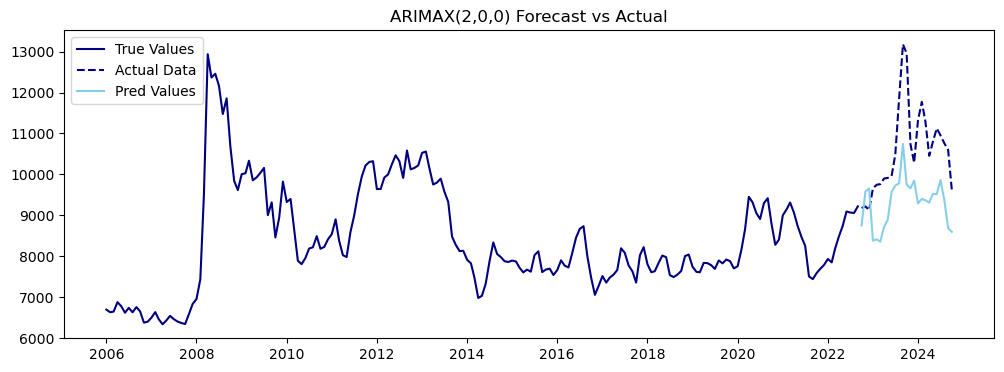

In [34]:
# Plot 
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label='True Values')
plt.plot(y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(arimax2_forecast, c='skyblue', label='Pred Values')
plt.title("ARIMAX(2,0,0) Forecast vs Actual")
plt.legend()

# saving the plot as an image
plt.savefig('../figure/water_fertilizer/ARIMAX(2,0,0) Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [36]:
arimax2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           nonglu_price   No. Observations:                  201
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1509.332
Date:                Thu, 19 Dec 2024   AIC                           3088.665
Time:                        11:21:22   BIC                           3204.280
Sample:                    01-01-2006   HQIC                          3135.448
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3214.7808   2030.961      1.583      0.113    -765.830    7195.392
hommali_price           0.2416      0.098      2.453      0.014       0.049       0.435
hommali_price_index     0.0033        nan        nan        nan         nan         nan
fertilizer_1           -0.1095      0.183     -0.598      0.550      -0.469       0.250
fertilizer_2           -0.0616      0.096     -0.639      0.523      -0.250       0.127
fertilizer_3            0.1149      0.145      0.792      0.428      -0.169       0.399
fertilizer_4            0.0214      0.083      0.259      0.795      -0.141       0.183
fertilizer_5            0.1893      0.182      1.041      0.298      -0.167       0.546
fertilizer_6           -0.0530      0.118     -0.450      0.653      -0.284       0.178
sirikit_water           0.4331      1.050      0.412      0.680      -1.625       2.491
bhumibol_water         -0.0014      0.324     -0.004      0.997      -0.636       0.633
water_station_B10      -5.7390      1.601     -3.585      0.000      -8.877      -2.601
water_station_C13      -0.1259      0.209     -0.601      0.548      -0.536       0.284
water_station_C2        0.1635      0.297      0.550      0.582      -0.419       0.746
water_station_G8        2.3612      3.009      0.785      0.433      -3.536       8.258
water_station_K10      -0.1746      0.464     -0.376      0.707      -1.083       0.734
water_station_K11A      0.3643      0.389      0.937      0.349      -0.398       1.127
water_station_Kgt3      0.2533      0.372      0.680      0.496      -0.476       0.983
water_station_Kh103     0.8397      4.768      0.176      0.860      -8.506      10.186
water_station_Kh58A    -0.5711      1.015     -0.563      0.574      -2.560       1.417
water_station_Kh72    -16.9813      5.538     -3.066      0.002     -27.836      -6.127
water_station_M6A      -0.1140      0.232     -0.492      0.623      -0.568       0.340
water_station_M7       -0.0258      0.086     -0.300      0.764      -0.194       0.143
water_station_N1       -0.7701      1.371     -0.562      0.574      -3.457       1.917
water_station_N67       0.0851      0.281      0.303      0.762      -0.465       0.636
water_station_Ny1B      0.0567      2.419      0.023      0.981      -4.684       4.797
water_station_P1       -2.2933      2.327     -0.986      0.324      -6.854       2.267
water_station_P17      -0.3739      0.287     -1.305      0.192      -0.935       0.188
water_station_S4B       1.6223      2.276      0.713      0.476      -2.838       6.082
water_station_Sw5A      1.9897      1.531      1.299      0.194      -1.012       4.991
water_station_Y17       0.3905      0.572      0.683      0.495      -0.730       1.511
water_station_Y1C       0.1179      0.854      0.138      0.890      -1.556       1.792
ar.L1                   0.9726      0.137      7.101      0.000       0.704       1.241
ar.L2                  -0.0985      0.146     -0.676      0.499      -0.3

## 4. GARCH Model

### Model 4 : GARCH

In [39]:
# Seed pseudorandom number generator
seed(1)

# Define model - fit on the residuals.
garch_model = arch_model(arimax2_model_residuals,mean='HARX', vol='GARCH', p=1, q=1, rescale=False)

# Fit model
garch_model_fit = garch_model.fit(disp='off')

# forecast the test set
garch_forecast = garch_model_fit.forecast(horizon=len(y_test), reindex=False)
garch_volatility = np.sqrt(garch_forecast.variance.values[-1])  # Convert to standard deviation

arimax_forecast = arimax2_model.get_forecast(steps=len(y_test), exog=X_test)
arimax_mean = arimax_forecast.predicted_mean

# combine ARIMAX Mean and GARCH Volatility
yhat = arimax_mean + garch_volatility  # Add GARCH volatility directly

In [40]:
# Evaluate the GARCH Model
garch_mse = mean_squared_error(y_test, yhat)
garch_rmse = root_mean_squared_error(y_test, yhat)
garch_r2 = r2_score(y_test, yhat)
print(f"GARCH Model MSE : {garch_mse:.4f}")
print(f"GARCH Model RMSE :{garch_rmse:.4f}")
print(f"GARCH Model R-squared :{garch_r2:.4f}")

GARCH Model MSE : 1409791.5248
GARCH Model RMSE :1187.3464
GARCH Model R-squared :-0.2819


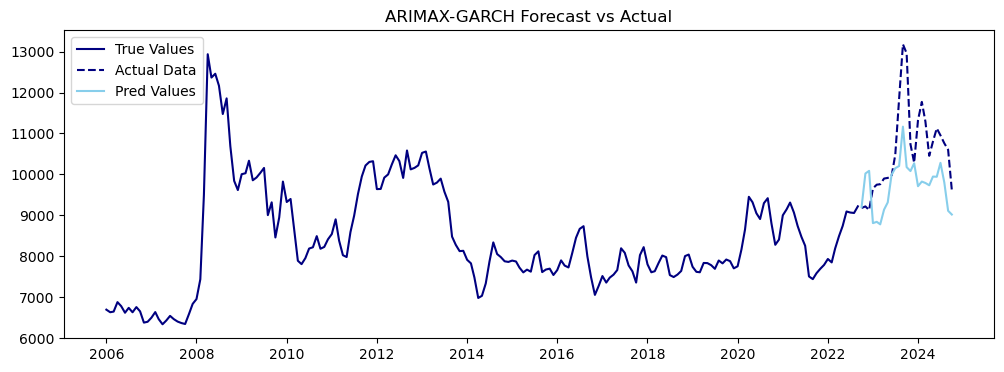

In [41]:
# Plot
plt.figure(figsize=(12, 4))
plt.plot(y_train, c='navy', label="True Values")
plt.plot(y_test.index, y_test, c='navy', linestyle='dashed', label="Actual Data")
plt.plot(y_test.index, yhat, c='skyblue', label="Pred Values")
plt.legend()
plt.title("ARIMAX-GARCH Forecast vs Actual")

# saving the plot as an image
plt.savefig('../figure/water_fertilizer/ARIMAX-GARCH Forecast vs Actual.png')
plt.show()

#### Feature Importance

In [43]:
print('GARCH Coefficients:')
print('omega (constant):', garch_model_fit.params['omega'])
print('alpha (ARCH term):', garch_model_fit.params['alpha[1]'])
print('beta (GARCH term):', garch_model_fit.params['beta[1]'])

GARCH Coefficients:
omega (constant): 54595.93791325935
alpha (ARCH term): 0.29756458528564306
beta (GARCH term): 0.3959496517066214


# Compare the score of models

In [45]:
score_df = pd.DataFrame(data = {'feature' : ['water and fertilizer'] * 3,
                                'model': ['Linear','ARIMAX(2,0,0)','GARCH'] , 
                                'MSE': [lr_mse,arimax2_mse,garch_mse], 
                                'RMSE': [lr_rmse,arimax2_rmse,garch_rmse], 
                                'R2': [lr_r2,arimax2_r2,garch_r2]})
score_df.to_csv('../data/cleaned_data/evaluation/water_fertilizer.csv',index=False)
score_df

,feature,model,MSE,RMSE,R2
0,water and fertilizer,Linear,3.485950e+06,1867.070013,-2.169770
1,water and fertilizer,"ARIMAX(2,0,0)",2.307787e+06,1519.140336,-1.098468
2,water and fertilizer,GARCH,1.409792e+06,1187.346422,-0.281922
